In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
import skimage.transform as sktr
import torch as to
import torch.nn as nn
import torchvision as tovi

In [2]:
%matplotlib inline

In [3]:
content = skio.imread("../../data/skyscrapper.jpg")
style   = skio.imread("../../data/starry_night_van_gogh.jpg")

print("content image shape \t : ", np.shape(content))
print("style image shape \t : ", np.shape(style))

content image shape 	 :  (479, 852, 3)
style image shape 	 :  (373, 595, 3)


In [4]:
content = sktr.resize(content, (512,512,3))
style   = sktr.resize(style,   (512,512,3))

/home/rishi/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/rishi/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


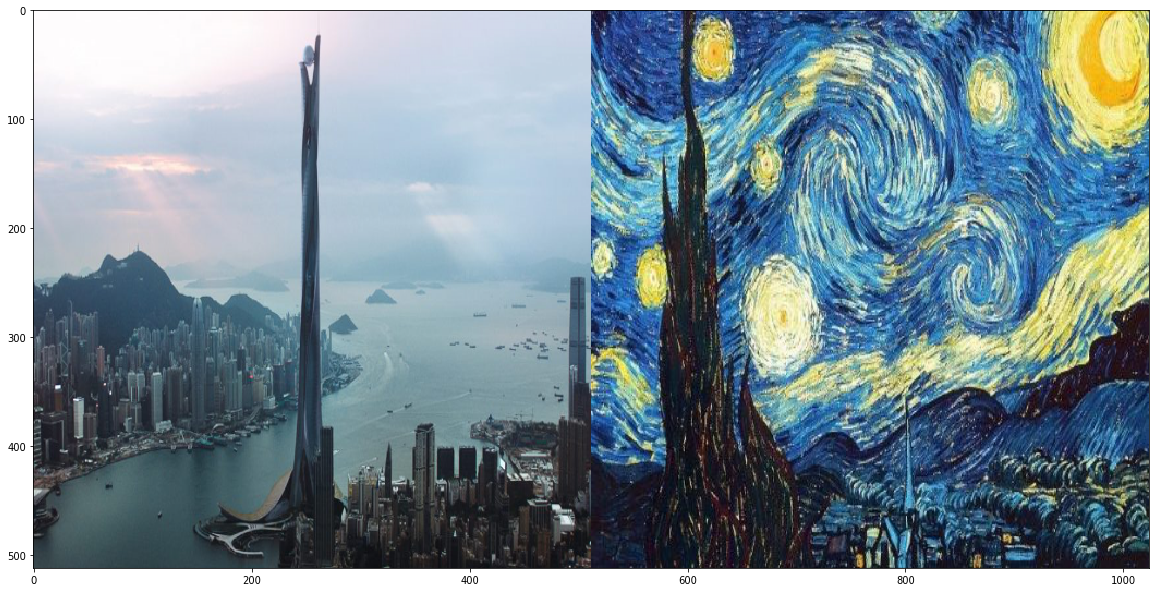

In [5]:
out = np.concatenate((content,style),axis=1)

plt.figure(figsize=(20,20))
plt.imshow(out)

In [6]:
VGG = tovi.models.vgg16(pretrained=True).features


for params in VGG.parameters():
    params.requires_grad=False

In [7]:

class Style_Transfer(nn.Module):
    
    def __init__(self,C_img,S_img,C_feature,S_feature):
        
        super (Style_Transfer,self).__init__()
        
        self.S_losses = []
        self.C_losses = []
        
        self.model = nn.Sequential(Normalize())

        i = 0

        for layer in VGG.children():

            if isinstance(layer, nn.Conv2d):
                i+=1
                name = 'conv_{}'.format(i)

            elif isinstance(layer, nn.ReLU):

                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False)

            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)

            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bnorm_{}'.format(i)

            else : 
                raise RuntimeError('Unrecognized Layer')

            self.model.add_module(name,layer)

            if name in C_feature :

                target = self.model(C_img).detach()
                loss = Content_loss(target)
                name = 'contentloss_{}'.format(i)
                self.model.add_module(name,loss)
                
                self.C_losses.append(loss)
                
            if name in S_feature :
                
                target = self.model(S_img).detach()
                loss = Style_loss(target)
                name = 'styleloss_{}'.format(i)
                self.model.add_module(name,loss)
                
                self.S_losses.append(loss)
                
        for i in range(len(self.model) - 1, -1, -1):
            if isinstance(self.model[i], Content_loss) or isinstance(self.model[i], Style_loss):
                break
                
        self.model = self.model[:(i + 1)]
       
                
        return
                
            
    def forward(self, x):
        
        x.data.clamp_(0, 1)
        
        out = self.model(x)
        
        return out, self.C_losses, self.S_losses


In [8]:
class Normalize(nn.Module):
    
    def __init__(self):
        
        super(Normalize,self).__init__()
        self.mean = to.tensor([0.485, 0.456, 0.406]).view(-1,1,1)
        self.std  = to.tensor([0.229, 0.224, 0.225]).view(-1,1,1)
        return

    def forward(self,img):
        
        return (img - self.mean) / self.std

In [9]:
def gram_matrix(input):
    
    a, b, c, d = input.size()  

    features = input.view(a * b, c * d) 

    G = to.mm(features, features.t()) 

    return G.div(a * b * c * d)


In [10]:
class Content_loss(nn.Module):
    
    def __init__(self, target):
        
        super(Content_loss,self).__init__()
        
        self.target = target
        
        return
    
        
    def forward(self, inp):
        
        self.loss = nn.functional.mse_loss(inp, self.target)
        
        return inp

In [11]:
class Style_loss(nn.Module):
    
    def __init__(self, target):
        
        super(Style_loss,self).__init__()

        G = gram_matrix(target)
        
        self.G = G
        
        return
    
    def forward(self, inp):
        
        G = gram_matrix(inp)
        
        self.loss = nn.functional.mse_loss(G, self.G)
        
        return inp
    

In [12]:
C = to.tensor(content.transpose(2,0,1).reshape(-1,3,512,512), dtype=to.float32)
S = to.tensor(style.transpose(2,0,1).reshape(-1,3,512,512), dtype=to.float32)
G = to.tensor(content.transpose(2,0,1).reshape(-1,3,512,512), dtype=to.float32, requires_grad=True)

In [13]:
epoch = 100
alpha = 1
beta = 100000
optimizer = to.optim.LBFGS([G])

In [14]:
content_feature = ['conv_4']
style_feature   = [ 'conv_2', 'conv_3', 'conv_4','conv_5']

In [15]:
Style = Style_Transfer(C,S,content_feature,style_feature)

In [16]:
out = 0

for i in range(epoch):
    
   
    
    def closure():
        
        
        optimizer.zero_grad()
        out, C_losses, S_losses = Style(G)
        
        s_score = 0
        c_score = 0
        
        for sl in S_losses :
            s_score+=sl.loss
        
        for cl in C_losses :
            c_score+=cl.loss
        
        loss = alpha*c_score + beta*s_score
        
        loss.backward()
        
        return alpha*c_score + beta*s_score
        
    optimizer.step(closure)
    
    print("\n i : ",i)
    G.data.clamp_(0, 1)
   
    if i==0 :
        
        G.data.clamp_(0, 1)
        out = G.detach().numpy()
        out = out.reshape(3, 512, 512)
        out = out.transpose(1,2,0)
        
        plt.figure(figsize=(20,20))
        plt.xlabel("epoch {}".format(i))
        plt.imsave("./run/epoch {}".format(i),out)
    
    elif i%20 == 0 :
        
        G.data.clamp_(0, 1)
        
        out = G.detach().numpy()
        out = out.reshape(3, 512, 512)
        out = out.transpose(1,2,0)
        
        plt.figure(figsize=(20,20))
        plt.xlabel("epoch {}".format(i))
        plt.imsave("./run/epoch {}".format(i),out)
        
        
    
        
    
     

epoch 0:
Style Loss : 0.021335 Content Loss: 0.000000

epoch 0:
Style Loss : 0.021334 Content Loss: 0.000000

epoch 0:
Style Loss : 0.009116 Content Loss: 11.449543

epoch 0:
Style Loss : 0.005433 Content Loss: 7.870894

epoch 0:
Style Loss : 0.003683 Content Loss: 10.572042

epoch 0:
Style Loss : 0.002848 Content Loss: 12.778996

epoch 0:
Style Loss : 0.002281 Content Loss: 13.617670

epoch 0:
Style Loss : 0.001874 Content Loss: 14.428638

epoch 0:
Style Loss : 0.001430 Content Loss: 16.596642

epoch 0:
Style Loss : 0.001056 Content Loss: 17.497494

epoch 0:
Style Loss : 0.000992 Content Loss: 18.747488

epoch 0:
Style Loss : 0.000833 Content Loss: 17.997700

epoch 0:
Style Loss : 0.000761 Content Loss: 18.724306

epoch 0:
Style Loss : 0.000682 Content Loss: 18.937994

epoch 0:
Style Loss : 0.000607 Content Loss: 20.008774

epoch 0:
Style Loss : 0.000496 Content Loss: 19.861797

epoch 0:
Style Loss : 0.000455 Content Loss: 20.704287

epoch 0:
Style Loss : 0.000402 Content Loss: 20.252

'""    \n    if i==0 :\n        \n        G.data.clamp_(0, 1)\n        out = G.detach().numpy()\n        out = out.reshape(3, 512, 512)\n        out = out.transpose(1,2,0)\n        out = sktr.resize(out,(256,256))\n    \n    elif i%50 == 0 :\n        \n        G.data.clamp_(0, 1)\n        o1 = G.detach().numpy()\n        o1 = o1.reshape(3, 512, 512)\n        o1 = o1.transpose(1,2,0)\n        o1 = sktr.resize(o1,(256,256))\n        \n        out = np.concatenate((out,o1),axis=1)\n'

/home/rishi/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/rishi/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


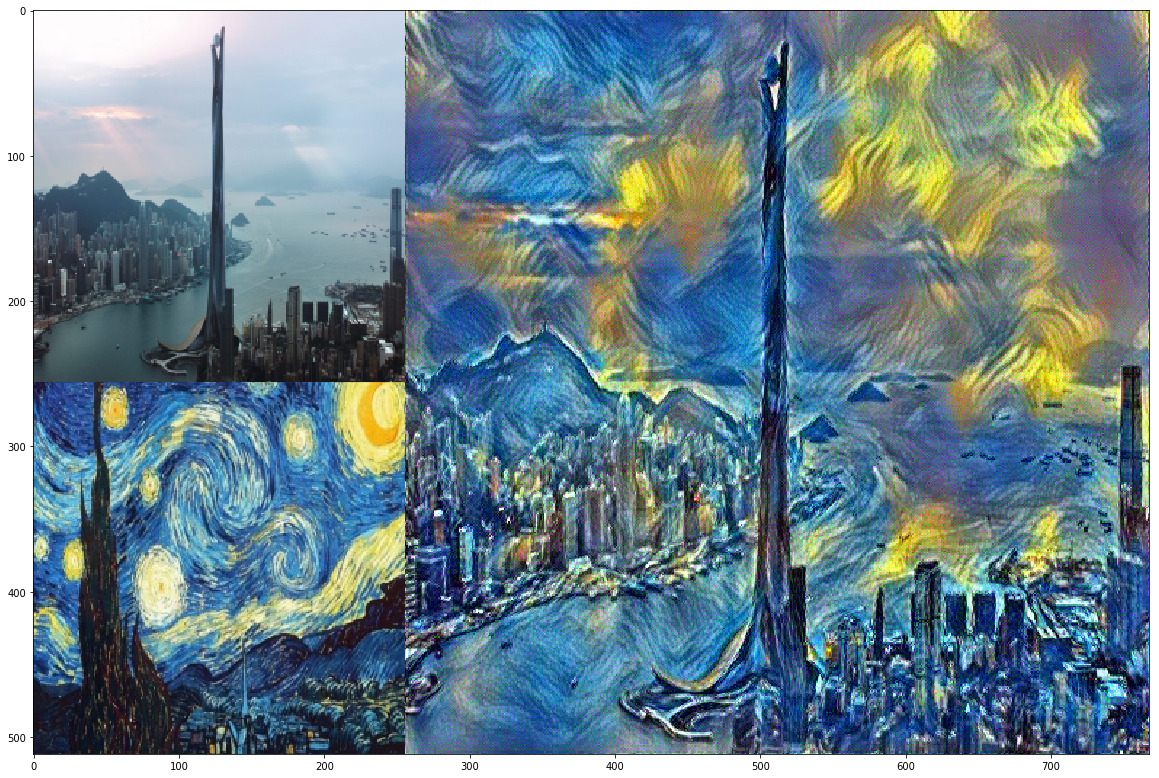

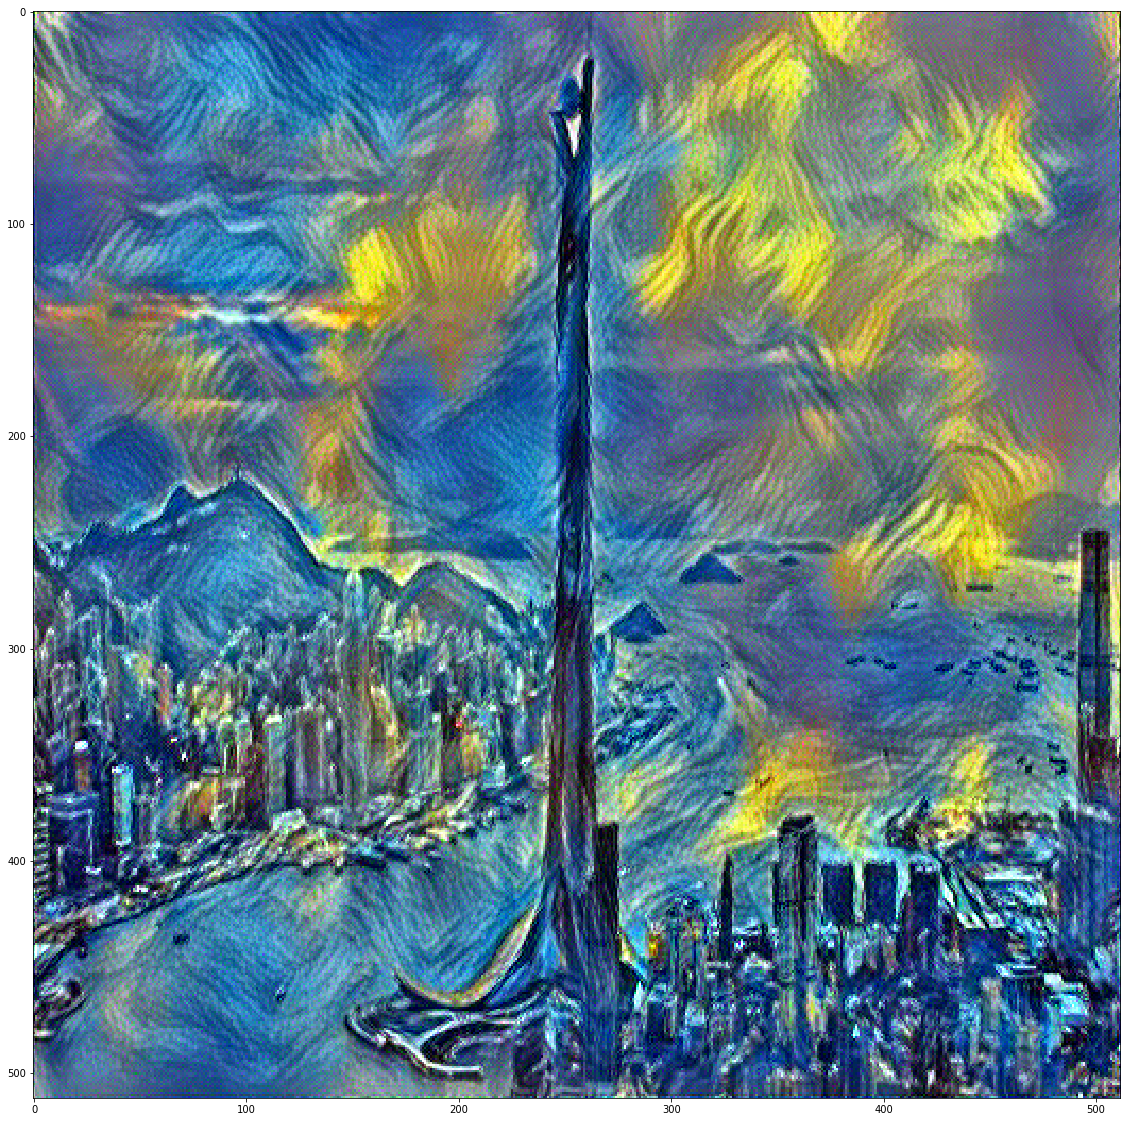

In [19]:
out = G.detach().numpy()
out = out.reshape(3, 512, 512)
out = out.transpose(1,2,0)

con = sktr.resize(content,(256,256))
sty = sktr.resize(style,(256,256))

o1 = np.concatenate((con,sty))
o2 = np.concatenate((o1,out),axis=1)

plt.figure(figsize=(20,20))
plt.imshow(o2)
plt.savefig("./final_compare")

plt.figure(figsize=(20,20))
plt.imshow(out)
plt.savefig("./final")